# Mixtral of Experts *with Neural Circuit Diagrams*
[Mixtral-8x7b](https://mistral.ai/news/mixtral-of-experts/) is the most exciting algorithm in deep learning. It is [open-source](https://github.com/mistralai/mistral-src/tree/moe) and was developed by a small Parisian team, yet, it ranks with the latest and most gargantuan models from OpenAI, Anthropic, Meta, and Google. It has superior performance to the initial release of ChatGPT, suggesting open-source is less than a year behind even OpenAI's (public) releases.

The architecture is shockingly simple and using [Neural Circuit Diagrams](https://openreview.net/forum?id=RyZB4qXEgt) we can follow the implementation step-by-step. We'll learn how to implement the below diagram, giving the tools to implement any other NCDs you come across.

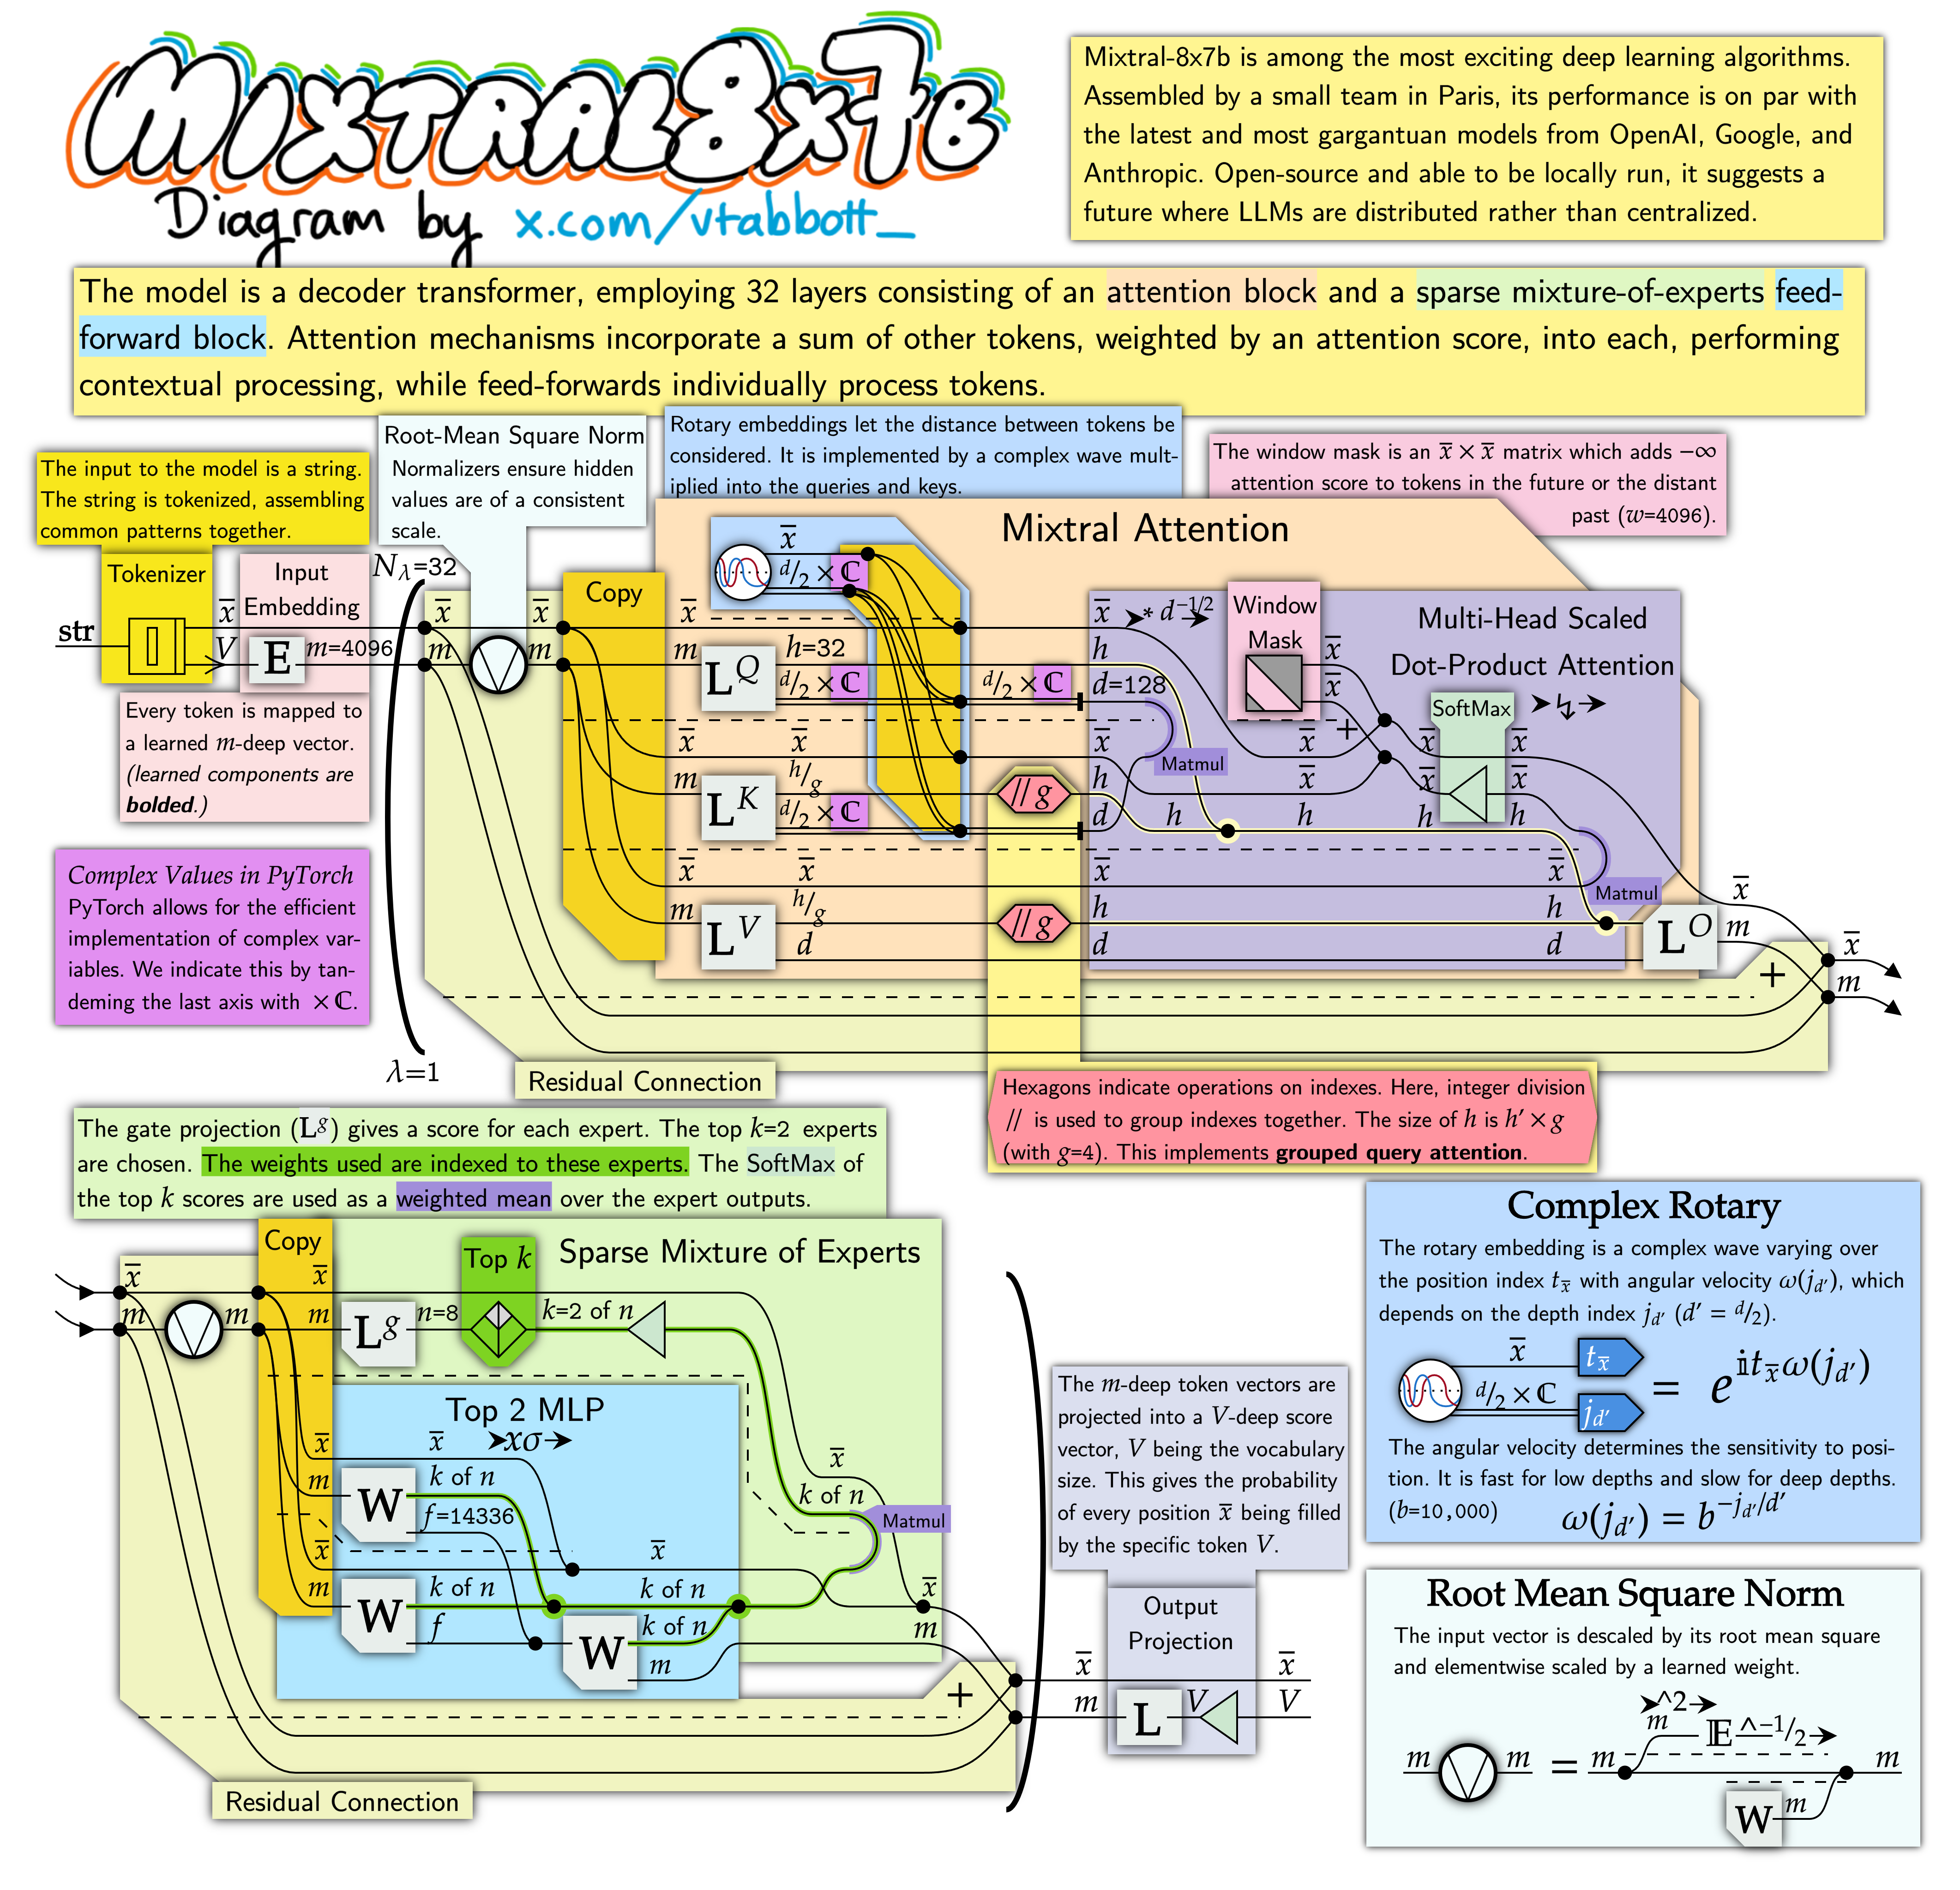

This guide will focus on implementing the model in PyTorch. If there's interest, I will make a second guide showing how to load weights and get the model running locally.

## Laying the Foundations
To follow this guide, some dependencies have to be loaded.

For better or worse, I use Windows. To follow along you'll need,
- [the CUDA Toolkit](https://developer.nvidia.com/cuda-12-1-0-download-archive)
- [Python](https://www.python.org/downloads/) (Download the latest version. You want to tick "Add to PATH". For the optional features, choose "Documentation" and "pip". Skip "tcl/tk" and "IDLE".)
- [VSCode](https://code.visualstudio.com/). Once installed, get the [Python](https://marketplace.visualstudio.com/items?itemName=ms-python.python) and [Jupyter](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) extensions.

Congrats! Edit out the # and run the code block below in Jupyter or a terminal without "% " (Ctrl + Shift + ` in VSCode) and you'll have all the packages ready.

In [1]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install jupyter einops

# The Overall Structure
We start by setting up the overall model. On a high level, we just go over the components and encompass them in an `nn.Module` class. For now, we'll be skipping the tokenizer (the yellow square coin). I will address it in a future guide where we load weights and get the model running locally!

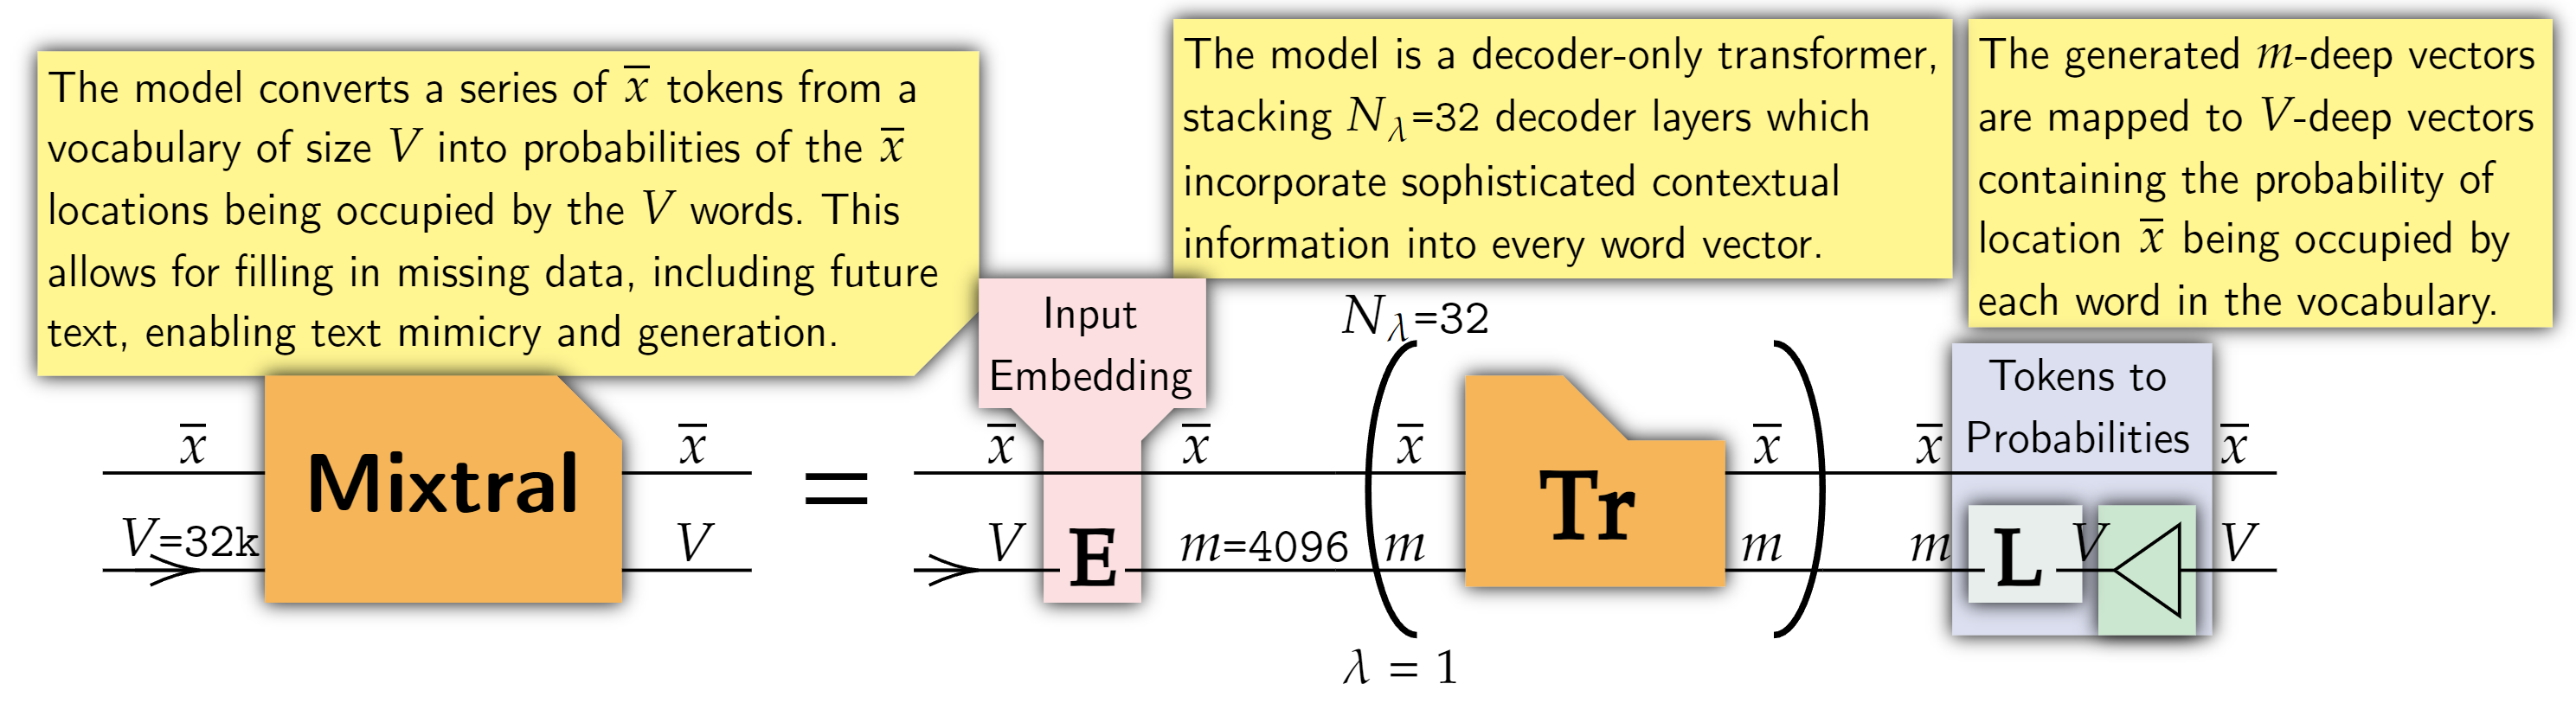

In [2]:
from typing import List, Optional, Tuple, Union, Any, Protocol

# Import the necessary packages.
import torch
import einops

import torch.functional as F
from dataclasses import dataclass
from torch import nn

# We work in multiples of this value.
# How conveniant of the decimal basis to choose 1000 to be so close to 2^10?
K = 1024

@dataclass
class MixtralArgs:
    """
    The model arguments. These correspond to all the _=_ throughout the diagram.
    """
    # Overall model settings.
    V       : int = 32*K
    n_layers: int = 2 # Is 32 in practice.
    m       : int = 4*K

    # Settings for the attention layer.
    d_h     : int = 128
    h       : int = 32
    g       : int = 4
    w       : int = 4*K
    chunk_size:int= K # How many tokens we process at once.

    # Settings for normalizers.
    rope_b  : int = 10000
    norm_eps:float= 1e-5

    # Settings for feed forward layers.
    f       : int = K # Is 14*K in practice.
    n_experts:int = 8
    k_experts:int = 2
    
    # How parameters are set up.
    module_kwargs    = {}
    parameter_kwargs = {}

class MixtralModel(nn.Module):
    def __init__(self, config : MixtralArgs) -> None:
        super().__init__()
        # We will be referncing this alot.
        c = config
        self.config = c
        V, m, n_layers = c.V, c.m, c.n_layers

        self.input_embedding = nn.Embedding(V, m)
        self.transformers = nn.Sequential(
            *[MixtralTransformer(config) for _ in range(n_layers)])
        self.output_projection = nn.Linear(m, V, bias=False)

    # The "forward" of an nn.Module indicates how it manipulates incoming data.
    def forward(self, xs : torch.Tensor):
        # xs : b x V*
        # b     represents the number of batches, implied on the diagram.
        # x     is x_bar, representing the number of related tokens.
        # V*    is the vocab size. The * or arrow on the diagram means this axis is not V real numbers, 
        #       rather, it is a single integer taking on values from 1 through V-1.
        xs = self.input_embedding(xs)
        for tf in self.transformers:
            xs = tf(xs)
        xs = self.output_projection(xs)
        xs = nn.functional.softmax(xs, dim=-1)
        return xs

# Implementing Transformers Part 1.
We've now set up the overall model structure! Now we get to the substance of Large Language Models (LLMs): transformers. These are composed of an attention mechanism for contextual processing and a feed forward layer for individual processing.

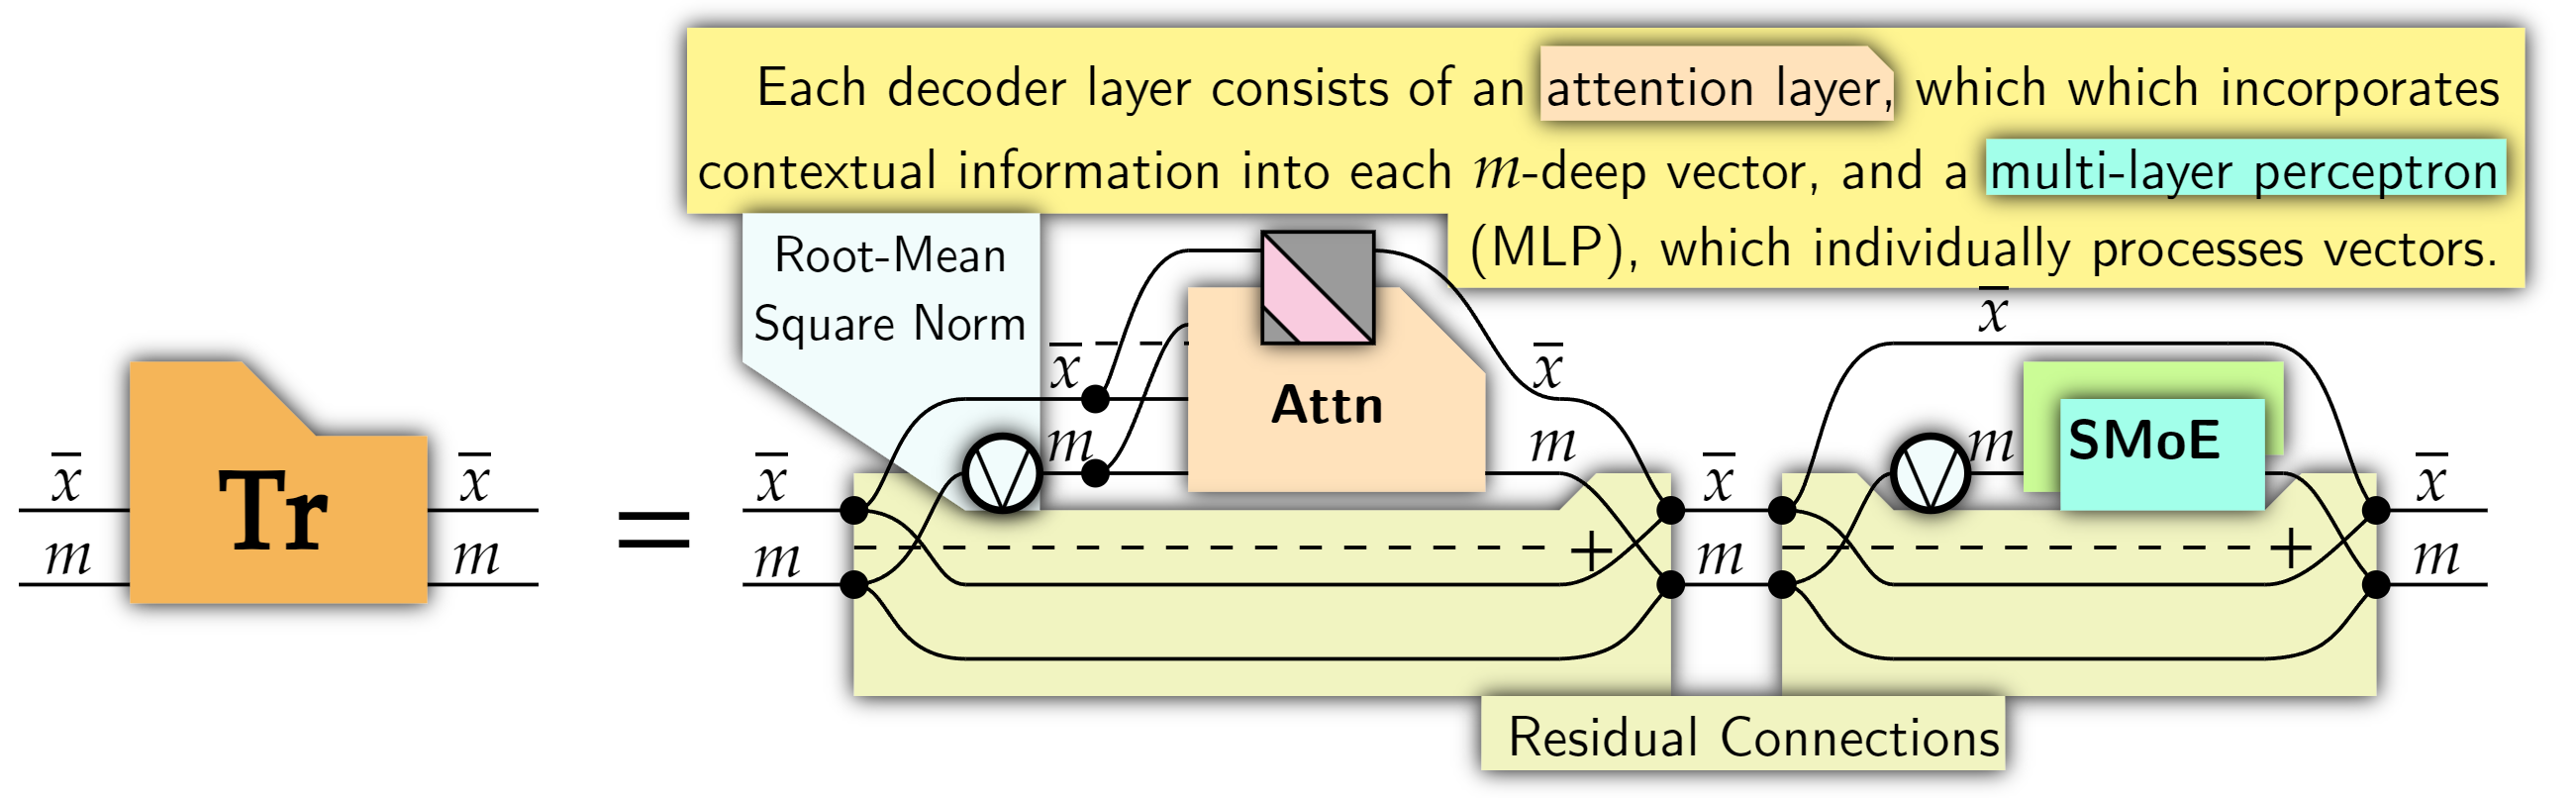

In [3]:
class MixtralTransformer(nn.Module):
    def __init__(self, config : MixtralArgs) -> None:
        super().__init__()
        self.config = config
        # Define the submodules,
        self.rms_at = RMSNorm(config)
        self.attn   = MixtralAttn(config)
        self.rms_ff = RMSNorm(config)
        self.smoe   = MixtralSMoE(config)

    def forward(self, xs):
        # xs: b x m (we read this from the diagram.)

        # We first feed to a normalizer, then use a residual connection.
        # (add output back to the input.)
        xs = xs + self.attn(self.rms_at(xs))
        xs = xs + self.smoe(self.rms_ff(xs))
        return xs

We also need to set up the RMSNorm, which isn't too complex. Note here that ... represents a collection of axes, other than the ones explicitly mentioned.

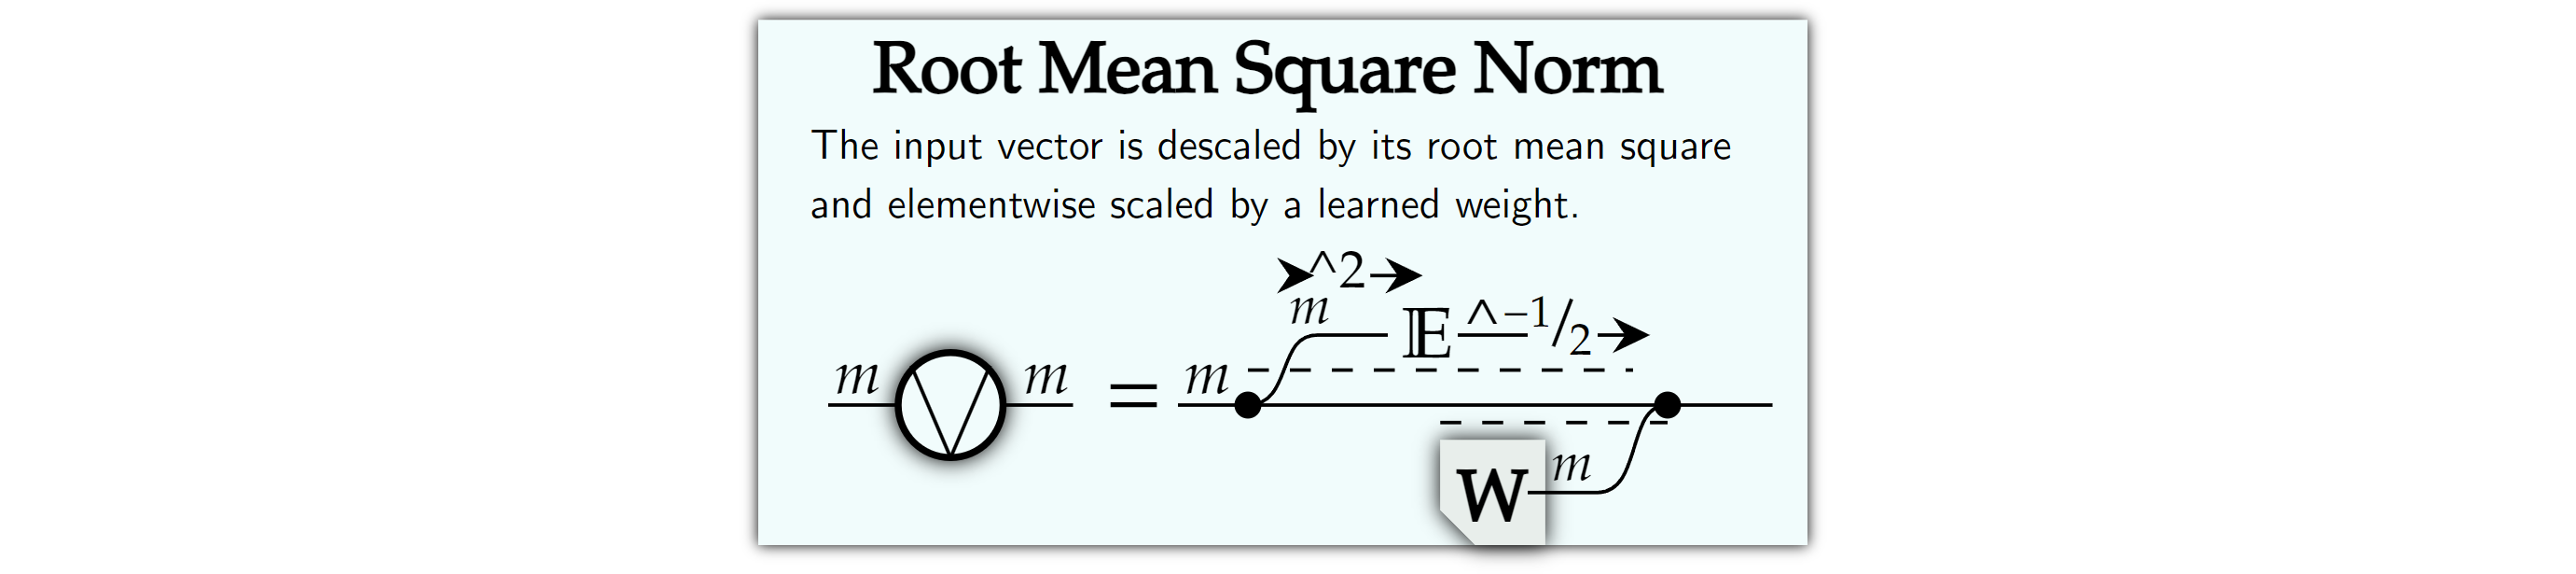

In [4]:
class RMSNorm(nn.Module):
    def __init__(self, config : MixtralArgs) -> None:
        super().__init__()

        self.config = config
        self.scales = nn.Parameter(torch.empty(config.m))

    def forward(self, xs):
        # xs : ... m
        # By setting keepdim = True, we keep a dimension of size 1. This
        # lets torch autobroadcasting apply it separately over the batched ...
        descale = torch.rsqrt(xs.pow(2).mean(dim=-1, keepdim=True)) # ... 1
        return einops.einsum(xs * descale, self.scales, "... m, m -> ... m")

# Implementing Transformers Part 2: Attention!
Now, we can implement the attention mechanism, the heart of LLMs. Attention mechanism which replace token vectors with weighted sums over other tokens. The weights are determined by "attention scores", which are derived from dot products between token queries and keys. This implements grammar, in a sense, letting tokens take each other into consideration.

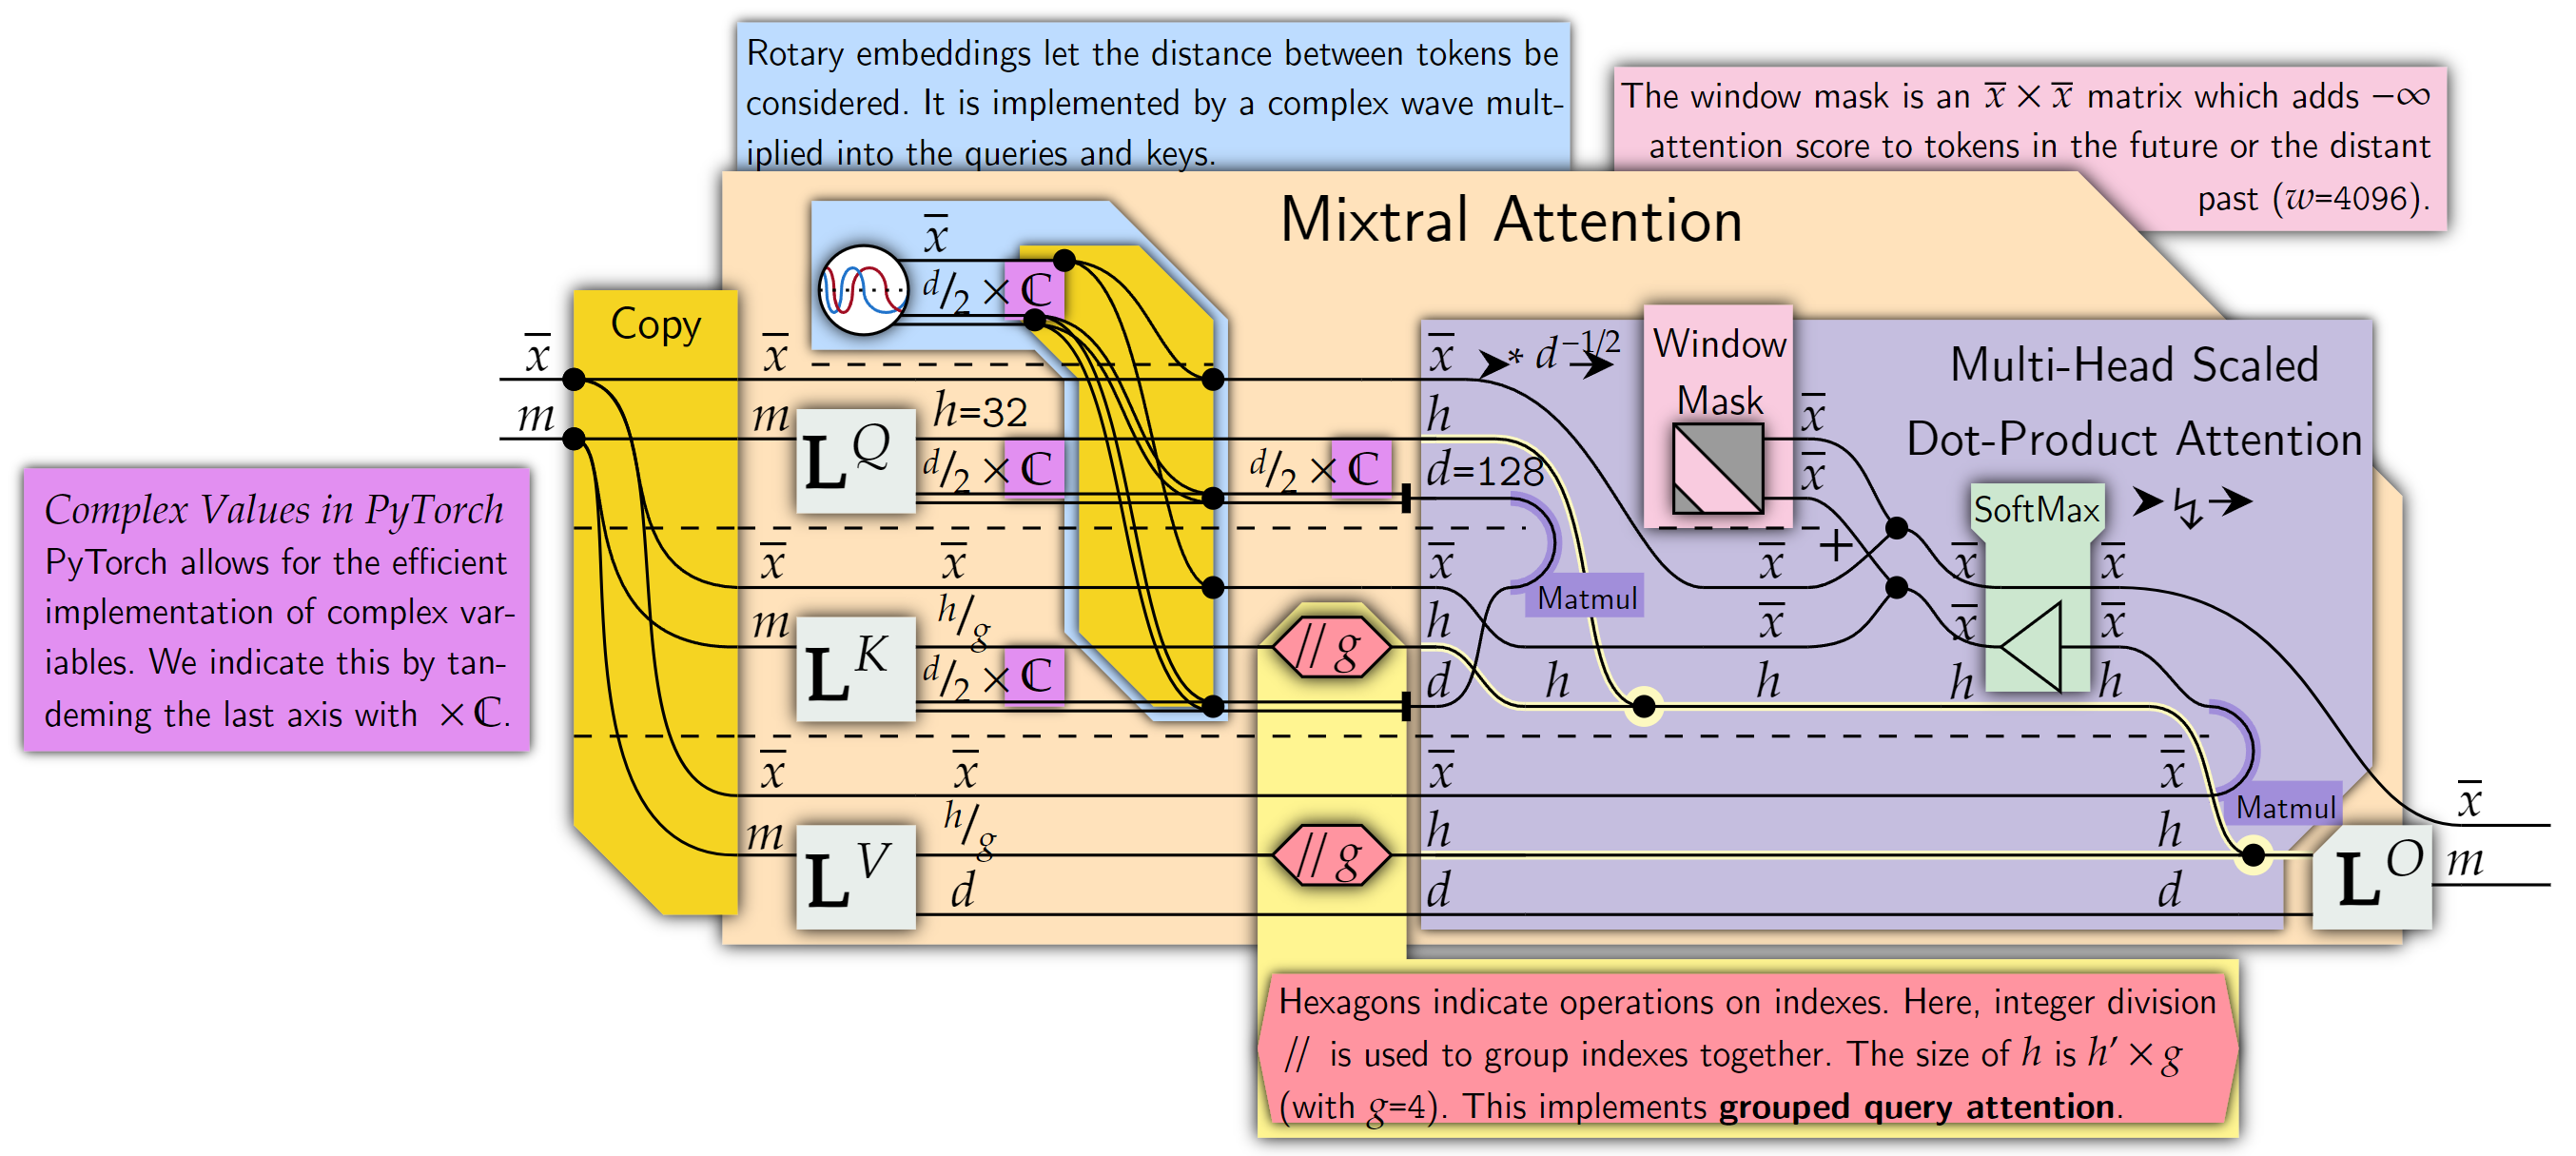

Note, that we will also be implementing the rotary embedding given by,
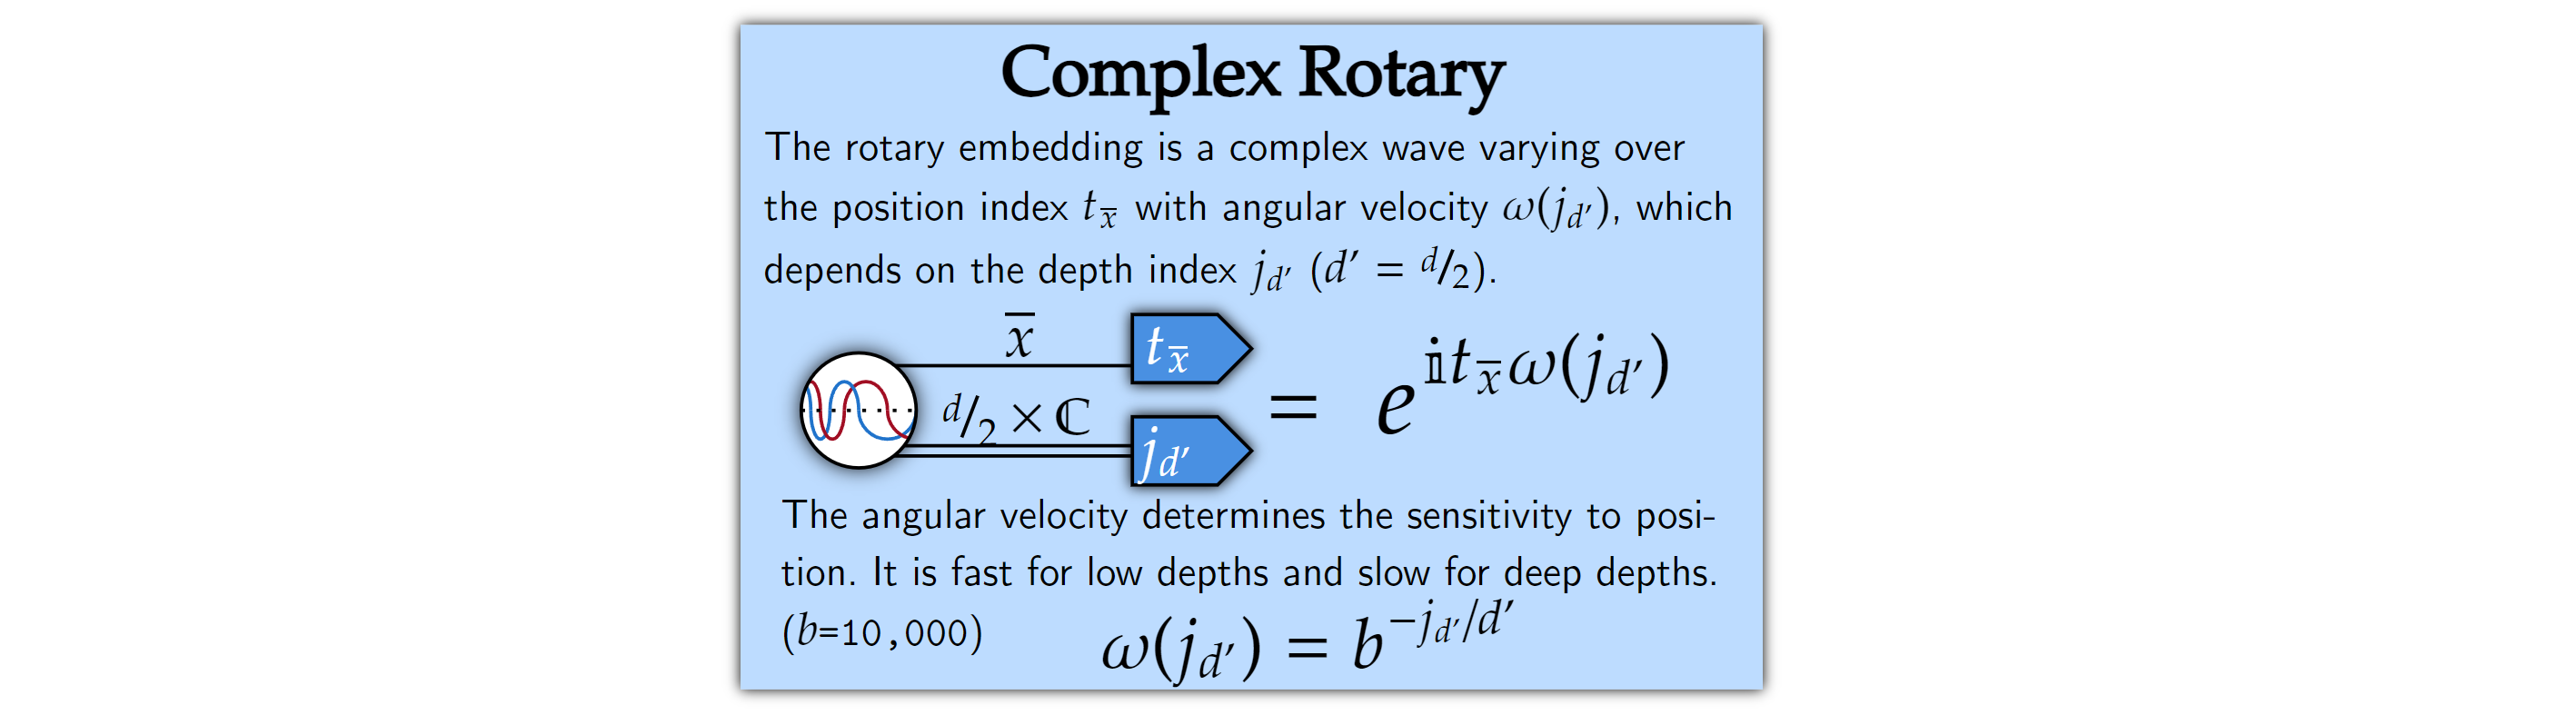

In [5]:
class MixtralAttn(nn.Module):
    def __init__(self, config : MixtralArgs) -> None:
        super().__init__()
        self.config = config
        c = config
        m, h, g, d = c.m, c.h, c.g, c.d_h

        # Define the linear layers.
        # Their input dimensions are the incoming wires, their outputs the outgoing wires.
        self.Lq = nn.Linear(m, h        * d, bias=False)
        self.Lk = nn.Linear(m, (h // g) * d, bias=False)
        self.Lv = nn.Linear(m, (h // g) * d, bias=False)
        self.Lo = nn.Linear(h * d, m       , bias=False)
    
    def rotary_embedding(self, x_bar):
        # We want to generate an x d/2 complex tensor.
        d2 = self.config.d_h // 2
        b  = self.config.rope_b
        angular_velocity = b ** (-torch.arange(d2) / d2) # d2
        # The .polar operation gives x*e^iy as a complex value.
        return torch.polar(
            torch.ones(x_bar, d2),
            einops.einsum(torch.arange(x_bar), angular_velocity, "x, d2 -> x d2")
        )
    
    def window_mask(self, x_bar):
        base = -torch.inf * torch.ones(x_bar, x_bar)
        # We return the w-away lower left corner and the upper right corner.
        # The other values are zero by the triangular lower and upper operations.
        return torch.tril(base, -self.config.w) + torch.triu(base, 1)

    def forward(self, xs : torch.Tensor):
        # xs: b x m (we read this from the diagram, and have an implied b.)
        b, x_bar, m = xs.size()
        h, g, d = self.config.h, self.config.g, self.config.d_h
        # The number of complex values
        d2 = d // 2

        # PROJECT IN
        vs = self.Lk(xs).view(b, x_bar, h // g, d)
        qs = torch.view_as_complex(self.Lq(xs).view(b, x_bar, h, d2, 2))
        ks = torch.view_as_complex(self.Lk(xs).view(b, x_bar, h // g, d2, 2))

        # ROTARY EMBEDDING
        complex_rotary = self.rotary_embedding(x_bar) # x d/2 (complex)
        qs = einops.einsum(qs, complex_rotary, "b x h d2, x d2 -> b x h d2")
        ks = einops.einsum(ks, complex_rotary, "b x h d2, x d2 -> b x h d2")
        qs = torch.view_as_real(qs).view(b, x_bar, h, d)
        ks = torch.view_as_real(ks).view(b, x_bar, h // g, d)

        # REPEAT HEADS
        # The inputs indicate which dimensions are repeated. 
        # In this case, the third. (with an implicit batch dimension.)
        ks = ks.repeat(1, 1, g, 1)
        vs = vs.repeat(1, 1, g, 1)
        
        # ATTENTION DOT PRODUCT
        qks  = einops.einsum(qs, ks, "b x1 h d2, b x2 h d2 -> b x1 x2 h")
        qks += self.window_mask(x_bar).view(1, x_bar, x_bar, 1)
        qks = nn.functional.softmax(qks, dim=-1)

        # FINAL MATMUL and PROJECTION OUT
        xs = einops.einsum(qks, vs, "b x1 x2 h, b x2 h d -> b x1 h d")
        xs = einops.rearrange(xs, "b x1 h d -> b x1 (h d)")
        xs = self.Lo(xs)
        
        return xs

# Transformers Part 3. Sparse Mixture-of-Experts
SMoEs are the "secret ingredient" to Mixtral. They let token vectors to "search" for alterations, and allow an enormous amount of information to be considered. They contain an overwhelming majority of the model's parameters and compute requirements.

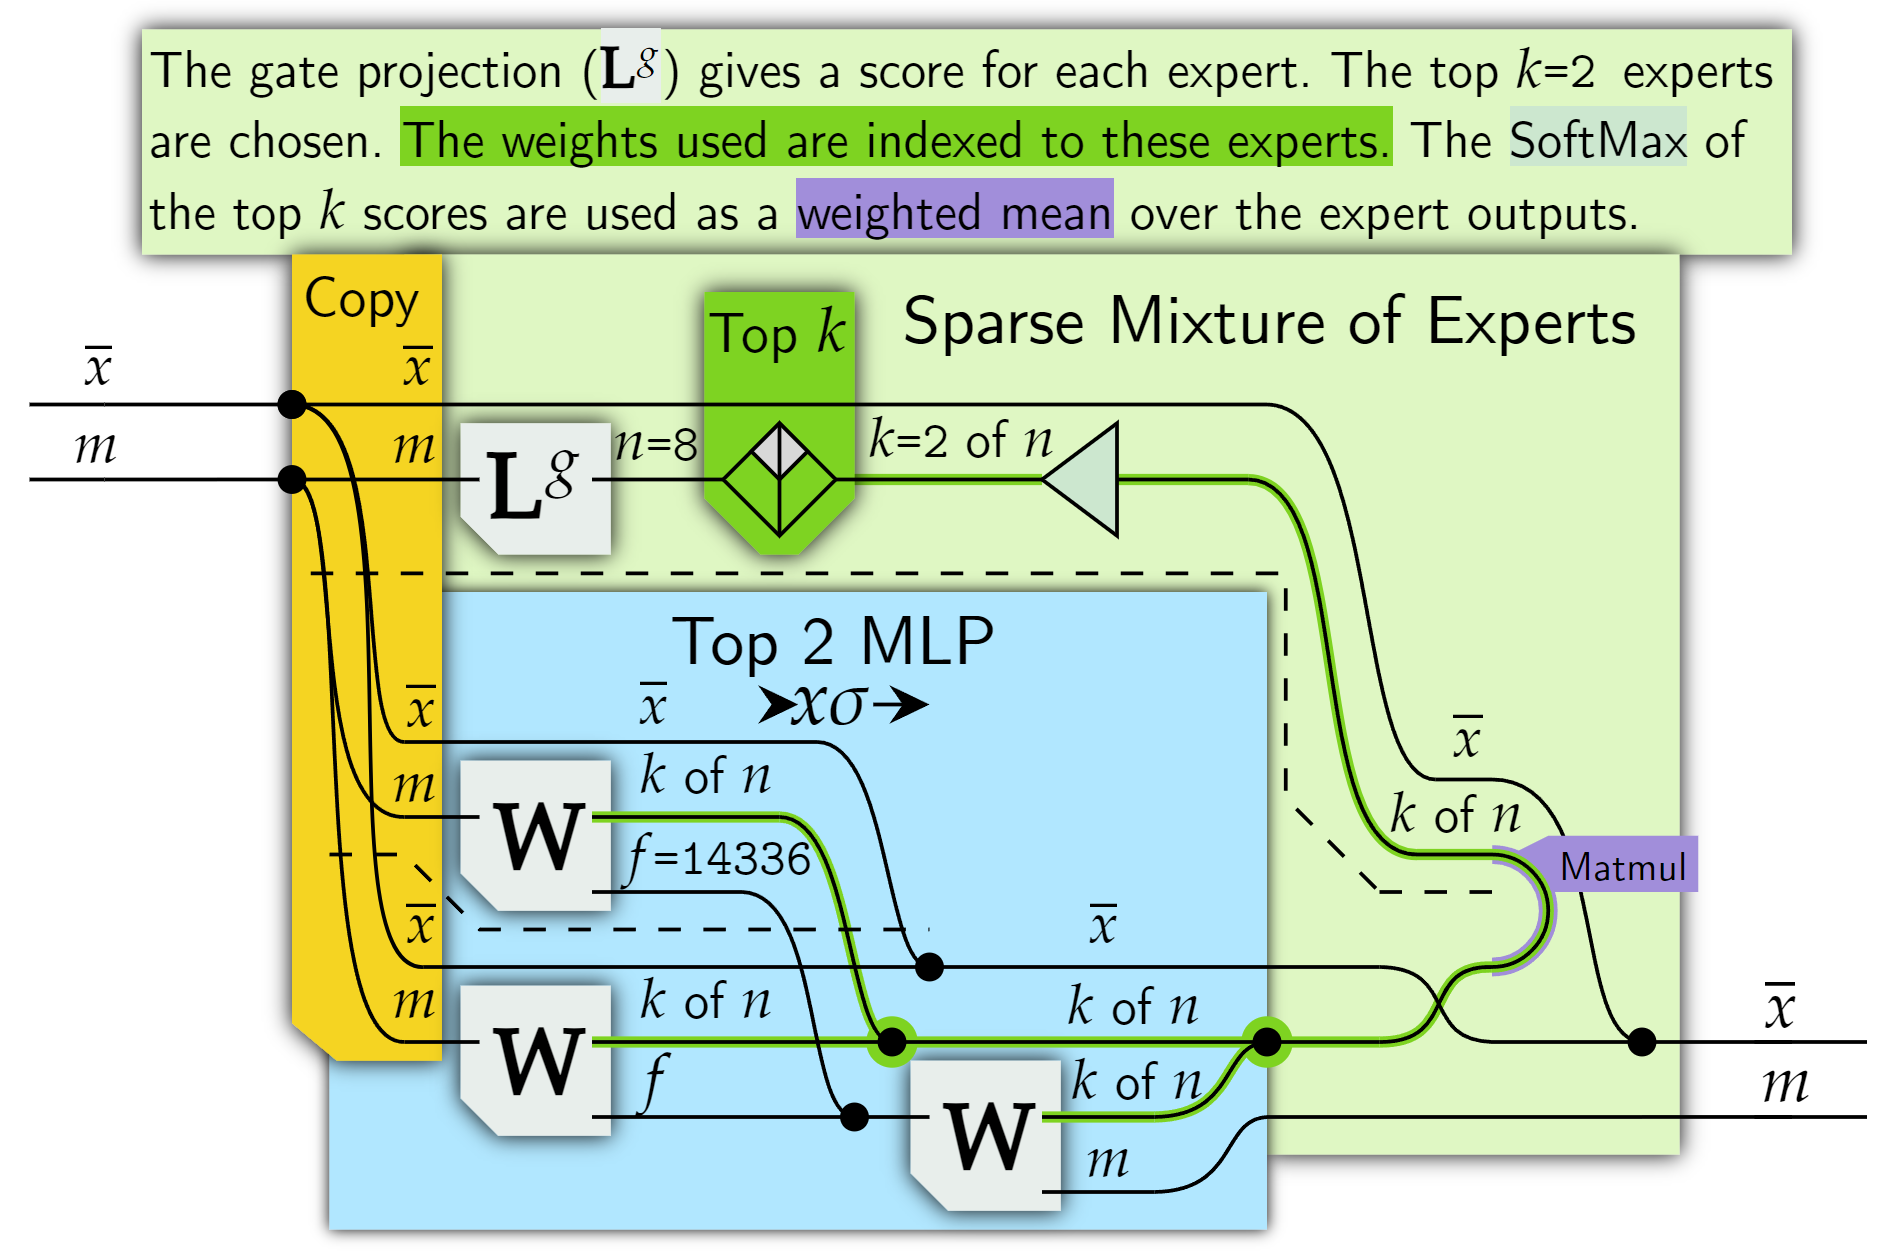

A Sparse-Mixture-of-Expert uses a linear gate to provide a score for every token for every expert. The top two experts for each token are computed.

In [6]:
class MixtralSMoE(nn.Module):
    def __init__(self, config: MixtralArgs) -> None:
        super().__init__()
        self.config = config
        # m: model dimension.
        # f: inner dimension.
        # n: number of experts.
        # k: number of used experts.
        m, f, n, k = config.m, config.f, config.n_experts, config.k_experts
        # Set up the learned weights.
        self.L_gate = nn.Linear(m, n, bias=False)
        self.W_act = nn.Parameter(torch.empty(n, m, f))
        self.W_in  = nn.Parameter(torch.empty(n, m, f))
        self.W_out = nn.Parameter(torch.empty(n, f, m))

        self.act = nn.functional.silu
    
    def forward(self, xs : torch.tensor):
        b, x, m = xs.size()
        # xs is b x m, we rearrange into bx m, as we individually process over batches and x_bar.
        xs.view(-1, m) 

        config = self.config
        m, f, n, k = config.m, config.f, config.n_experts, config.k_experts

        # Get the top values first
        expert_scores = self.L_gate(xs)
        top_scores, top_indexes = expert_scores.topk(k) # bx k, bx k n*
        top_scores = nn.functional.softmax(top_scores, dim=-1)

        # We loop over experts, adding their outputs.
        # For every expert, we only compute active tokens. 
        x_out = torch.zeros(*xs.size())
        for ni in range(n):
            # Get the indexes over which this expert is active.
            # We contract the k index of top_indexes == ni (shape bx k 2*) to get a bx list of Booleans.
            active_indexes = (top_indexes == ni).any(dim=-1) # bx 2* (Boolean)
            if not active_indexes.any():
                continue # Skip inactive experts.

            relevant_scores = top_scores[top_indexes == ni] # a, where a are the number of active indexes.

            # The non-linearized values.
            xs_act = self.act(einops.einsum(
                xs[active_indexes], self.W_act[ni],
                "a m, m f -> a f"))
            # The linear values.
            xs_lin = einops.einsum(
                xs[active_indexes], self.W_in[ni],
                "a m, m f -> a f")
            # Compute the linear operations.
            xs_lin = einops.einsum(
                xs_act, xs_lin,
                "a f, a f -> a f")
            xs_lin = einops.einsum(
                xs_lin, self.W_out[ni],
                "a f, f m -> a m")
            # Accumulate relevant scores.
            x_out[active_indexes] += einops.einsum(
                xs_lin, relevant_scores,
                "a m, a -> a m")

        return x_out.view(b, x, m)

# Running the Model
We can now feed some dummy inputs to our dummy model! The output will, of course, be useless, as we haven't integrated any weights. Furthermore, the algorithm right now is not optimized. We don't take advantage of windowed attention, KVCaching, flash attention or quantization. These don't change the underlying mathematics of the model, its the same model, but they allow it to run more efficiently and to be fit on a local device.

In [7]:
# We initialize the model!
model = MixtralModel(MixtralArgs())
# Have some inputs - this is a b x V* tensor. The tensor is composed of indexes of the vocab tokens.
inputs = torch.tensor([[1,2]], dtype=torch.long)
print(model(inputs))
print(model)

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], grad_fn=<SoftmaxBackward0>)
MixtralModel(
  (input_embedding): Embedding(32768, 4096)
  (transformers): Sequential(
    (0): MixtralTransformer(
      (rms_at): RMSNorm()
      (attn): MixtralAttn(
        (Lq): Linear(in_features=4096, out_features=4096, bias=False)
        (Lk): Linear(in_features=4096, out_features=1024, bias=False)
        (Lv): Linear(in_features=4096, out_features=1024, bias=False)
        (Lo): Linear(in_features=4096, out_features=4096, bias=False)
      )
      (rms_ff): RMSNorm()
      (smoe): MixtralSMoE(
        (L_gate): Linear(in_features=4096, out_features=8, bias=False)
      )
    )
    (1): MixtralTransformer(
      (rms_at): RMSNorm()
      (attn): MixtralAttn(
        (Lq): Linear(in_features=4096, out_features=4096, bias=False)
        (Lk): Linear(in_features=4096, out_features=1024, bias=False)
        (Lv): Linear(in_features=4096, out_features=1024, 